In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants


from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

Gtk-Message: 16:22:14.554: Failed to load module "canberra-gtk-module"


In [3]:
# organisation of directory and creation of preprocessing folders
dataset_id = 'subject101410'
subject = '101410' 

sample_path = "/home/jovyan/data"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)



###################
# Create folders relevant for preprocessing..
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-101410'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'func'))
mkdir_no_exist(op.join(preproc_root, 'sub-101410', 'fmap')) 

In [24]:
print_dir_tree(bids_root, max_depth=5)

|subject101410/
|--- dataset_description.md
|--- task-motor_bold.json
|--- T1w/
|------ T1w.nii.gz
|--- derivatives/
|------ preprocessed_data/
|--------- sub-101410/
|------------ anat/
|--------------- sub-101410_T1w.nii.gz
|--------------- sub-101410_T1w_fast_mixeltype.nii.gz
|--------------- sub-101410_T1w_fast_pve_0.nii.gz
|--------------- sub-101410_T1w_fast_pve_1.nii.gz
|--------------- sub-101410_T1w_fast_pve_2.nii.gz
|--------------- sub-101410_T1w_fast_pveseg.nii.gz
|--------------- sub-101410_T1w_fast_seg.nii.gz
|--------------- sub-101410_T1w_mask.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-101410_task-motor_concat_varnorm.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.nii.gz
|--------------- sub-101410_task-motor_concat_varnorm_moco.par
|--------------- sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz
|--------------- sub-101410_task-motor_func2anat.nii.gz
|--------------- tfMRI_MOTOR_LR_varnorm.nii.gz
|--------------

In [25]:
print(preproc_root)
print(bids_root)

/home/jovyan/data/NSSP_project1_GroupK/subject101410/derivatives/preprocessed_data
/home/jovyan/data/NSSP_project1_GroupK/subject101410


In [26]:
#skull-stripping
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format (which we will cover in the following weeks).
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping (you'll learn more about it next week!).
    # For now all you need to do is that we remove the bones and flesh from the MRI to get the brain!
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz')
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "101410")

Done with BET.


In [28]:
# robust skull stripping
get_skull_stripped_anatomical(bids_root, preproc_root, "101410", robust = True)

Done with BET.


In [30]:
# applying the mask to the data to create the skull stripped version and save it
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_mask.nii.gz') # The mask to use


apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)


In [ ]:
#plots for report
from nilearn.plotting import plot_anat
import matplotlib.pyplot as plt

anatomical_path = op.join(bids_root, 'T1w', 'T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # The brain without skull is in the derivatives folder

plot_anat(anatomical_path, title="Before Skull Stripping")
plot_anat(betted_brain_path, title="After Skull Stripping")
plt.show()


In [9]:
# tissue segmentation
fast_target = betted_brain_path

segmentation_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w_fast')


if not os.path.exists(segmentation_path + "_seg.nii.gz"):
    fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

PathError: Could not find a supported file with prefix "/home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/anat/sub-101410_T1w.nii.gz"

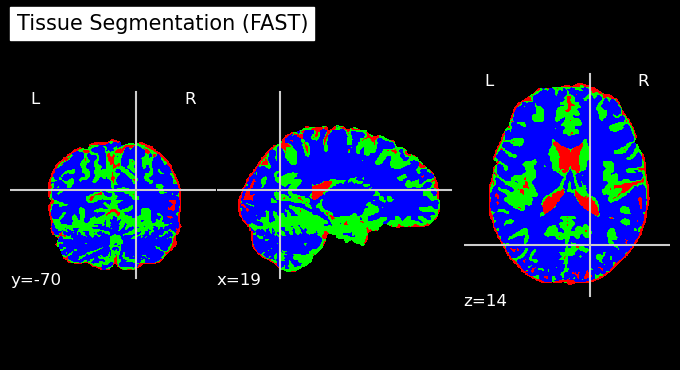

In [16]:
# plot for report
import os, glob
from nilearn import plotting
import matplotlib.pyplot as plt
import os.path as op
from matplotlib.colors import LinearSegmentedColormap

# Base anatomical image (skull stripped)
anat_path = betted_brain_path

# Segmentation maps from FAST (probability maps)
pve_0 = glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*pve_0*'))[0]  # CSF
pve_1 = glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*pve_1*'))[0]  # GM
pve_2 = glob.glob(op.join(preproc_root, 'sub-101410', 'anat', '*pve_2*'))[0]  # WM

# Create solid colormaps
red_cmap = LinearSegmentedColormap.from_list('red', [(1,0,0,1),(1,0,0,1)])
green_cmap = LinearSegmentedColormap.from_list('green', [(0,1,0,1),(0,1,0,1)])
blue_cmap = LinearSegmentedColormap.from_list('blue', [(0,0,1,1),(0,0,1,1)])


# Plot them overlaid with color maps
display = plotting.plot_anat(anat_path, title="Tissue Segmentation (FAST)", display_mode='ortho')

display.add_overlay(pve_0, cmap=red_cmap)   
display.add_overlay(pve_1, cmap=green_cmap)    
display.add_overlay(pve_2, cmap=blue_cmap)  

plt.show()



In [17]:
# rescaling data for concatenation
path_runLR = op.join(bids_root, "fMRI", "tfMRI_MOTOR_LR", "tfMRI_MOTOR_LR.nii")
path_runRL = op.join(bids_root, "fMRI", "tfMRI_MOTOR_RL", "tfMRI_MOTOR_RL.nii")
out_dir = op.join(preproc_root, "sub-101410", "func")

def rescale_global_variance(img_path, out_dir, mask = None):
    img = nib.load(img_path)
    data = img.get_fdata() # data is an np.array, easier for rescaling

    if mask == None :
        mask = data.mean(axis=-1) > 0 # mask takes voxels with intensity (not the background)
        
    
    brain_voxels = data[mask]
    # remove the mean
    without_mean = brain_voxels - brain_voxels.mean(axis=1, keepdims=True)
    global_var = np.var(without_mean)
    print(f"{os.path.basename(img_path)}: global variance = {global_var:.4f}")

    scaled = data / np.sqrt(global_var)

    # esave the rescaled image
    base = os.path.splitext(os.path.basename(img_path))[0]
    out_path = op.join(out_dir, base + "_varnorm.nii.gz")
    nib.save(nib.Nifti1Image(scaled, img.affine, img.header), out_path)
    return out_path



out_runLR = rescale_global_variance(path_runLR, out_dir) # could be done with our mask as well
out_runRL = rescale_global_variance(path_runRL, out_dir)


tfMRI_MOTOR_LR.nii: global variance = 311884.1305
tfMRI_MOTOR_RL.nii: global variance = 275731.3405


In [18]:
# concatenate the normalised runs
from nibabel import concat_images

run1_norm = op.join(out_dir, "tfMRI_MOTOR_LR_varnorm.nii.gz")
run2_norm = op.join(out_dir, "tfMRI_MOTOR_RL_varnorm.nii.gz")

merged_out = op.join(out_dir, "sub-101410_task-motor_concat_varnorm.nii.gz")

concat_img = concat_images([run1_norm, run2_norm], axis=3)
nib.save(concat_img, merged_out)

In [19]:
# motion correction
from fsl.wrappers import mcflirt

path_original_data = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm.nii.gz")
path_moco_data = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco")
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [20]:
# get and show motion parameters
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_varnorm_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000476,-0.005768,-0.002684,-0.330166,-0.163757,0.138294
1,0.000354,-0.005786,-0.002623,-0.328654,-0.164137,0.154693
2,0.000332,-0.006068,-0.002684,-0.331812,-0.155653,0.156803
3,0.000681,-0.005509,-0.002618,-0.332109,-0.156072,0.168333
4,0.000596,-0.005828,-0.002344,-0.334126,-0.155673,0.153350
...,...,...,...,...,...,...
563,0.000479,0.000813,-0.000212,0.052787,-0.037655,0.063665
564,0.000580,0.000813,-0.000331,0.064822,-0.038180,0.053299
565,0.000599,0.000813,-0.000288,0.053048,-0.047310,0.062754
566,0.000498,0.000813,-0.000284,0.051613,-0.043683,0.067995


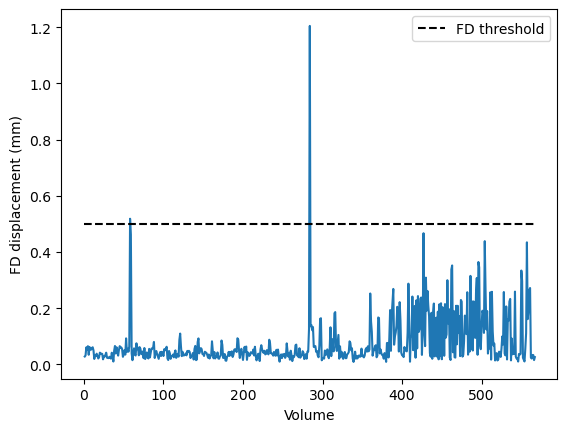

Volumes outliers: [ 57 283]


In [23]:
# framewise displacement plot
import matplotlib.pyplot as plt

def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
threshold = 0.5 
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 567,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()
outliers = np.where(fd > threshold)[0]
print("Volumes outliers:", outliers)

In [26]:
# outlier detection
threshold = 0.5             # FD threshold in mm
output_file = "spike_regressors.txt"  # noutput file name

n_volumes = len(fd)
outliers = np.where(fd > threshold)[0]
print(f"Seuil FD = {threshold} mm → {len(outliers)} outliers détectés : {outliers}")

X_spikes = np.zeros((n_volumes, len(outliers)))

for i, vol in enumerate(outliers):
    X_spikes[vol, i] = 1

spike_names = [f"outlier_{i}" for i in outliers]
df_spikes = pd.DataFrame(X_spikes, columns=spike_names)

df_spikes.to_csv(output_file, sep='\t', index=False)

print(f"Fichier sauvegardé : {output_file}")
print(f"Dimensions : {df_spikes.shape[0]} volumes × {df_spikes.shape[1]} régressors")


Seuil FD = 0.5 mm → 2 outliers détectés : [ 57 283]
Fichier sauvegardé : spike_regressors.txt
Dimensions : 567 volumes × 2 régressors
     outlier_57  outlier_283
0           0.0          0.0
1           0.0          0.0
2           0.0          0.0
3           0.0          0.0
4           0.0          0.0
..          ...          ...
562         0.0          0.0
563         0.0          0.0
564         0.0          0.0
565         0.0          0.0
566         0.0          0.0

[567 rows x 2 columns]


In [1]:
# co-registration
from fsl.wrappers import flirt
# Paths
anat_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz') # source
func_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco.nii.gz")# reference

# Output 
out_dir = op.join(preproc_root, "sub-101410", "func")
out_func2anat = op.join(out_dir, "sub-101410_task-motor_func2anat.nii.gz")


flirt(func_path, anat_path, out=out_func2anat)

NameError: name 'op' is not defined

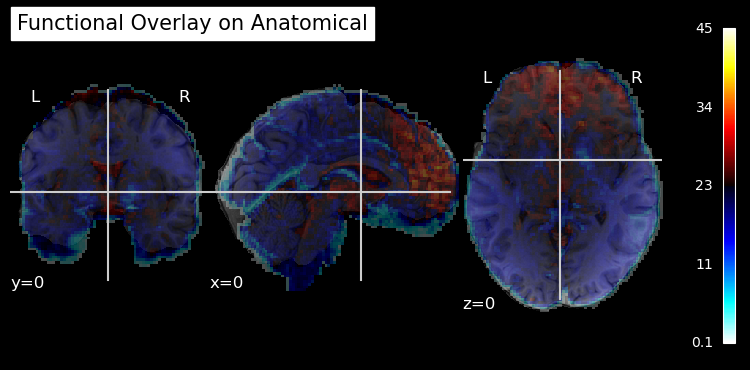

In [24]:
#  overlay plot
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import os.path as op

# Paths
anat_path = op.join(preproc_root, 'sub-101410', 'anat', 'sub-101410_T1w.nii.gz')
func_path = op.join(preproc_root, 'sub-101410', 'func', 'sub-101410_task-motor_concat_varnorm_moco.nii.gz')

# Pick a single volume 
func_img = index_img(func_path, 100)  

# Solid red colormap (FSLeyes-style)
red_cmap = LinearSegmentedColormap.from_list('red', [(1,0,0,1),(1,0,0,1)])

# Plot overlay: functional on top of anatomical
plot_stat_map(func_img, bg_img=anat_path,
              display_mode='ortho',
              title="Functional Overlay on Anatomical",
              threshold=0.1,      # ignore near-zero voxels
              cut_coords=(0, 0, 0),
              alpha=0.3,          # transparency
              colorbar=True)      # default colormap (gray/yellow)

plt.show()


In [26]:
# gaussian smoothing, with FWHM of 6mm
import os
import subprocess
import os.path as op

output_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco.nii.gz")
# for correct naming of file
base_path = output_path.replace('.nii.gz', '')
sigma = 6 / 2.3548
subprocess.run(['fslmaths', output_path, '-s', str(sigma), f'{base_path}_smoothed-6mm'])


CompletedProcess(args=['fslmaths', '/home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco.nii.gz', '-s', '2.547987090198743', '/home/jovyan/data/subject101410/derivatives/preprocessed_data/sub-101410/func/sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm'], returncode=0)

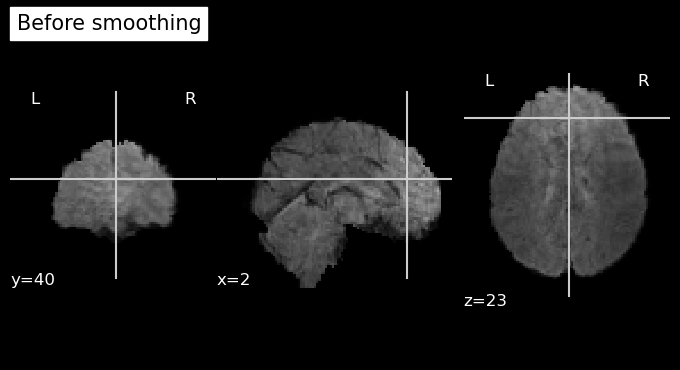

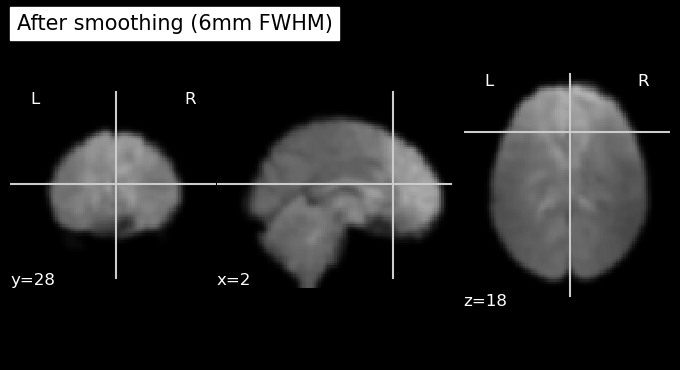

In [27]:
# smoothing plot for report
from nilearn.plotting import plot_anat
from nilearn.image import index_img
import nibabel as nib
import matplotlib.pyplot as plt
import os.path as op

# Paths
before_path = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco.nii.gz")
after_path  = op.join(preproc_root, "sub-101410", "func", "sub-101410_task-motor_concat_varnorm_moco_smoothed-6mm.nii.gz")

# Load functional images
before_img = nib.load(before_path)
after_img  = nib.load(after_path)

before_img = index_img(before_path, 100)  
after_img = index_img(after_path, 100) 



plot_anat(before_img, display_mode='ortho', title="Before smoothing")
plot_anat(after_img,  display_mode='ortho', title="After smoothing (6mm FWHM)")

plt.show()
